# Music Box Churn Prediction and Recommendation using Spark

# Using Spark to train model

# Goal:

In [1]:
from pyspark import SparkContext
from pyspark.sql.session import SparkSession

In [2]:
# sc = SparkContext('local')
# spark = SparkSession(sc)

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors, DenseVector
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer

## 1. Load data

In [5]:
df = spark.read.csv('data/model_final.csv', header=True, inferSchema=True).cache()

In [6]:
df.show()

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+----------------------+----------------------+----------------------+-----------------+-----------------+-----------------+------------------+------------------+--------+--------+--------+---------+---------+
|      uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|device_type|days_from_last_P_evnet|days_from_last_S_evnet|days_from_last_D_evnet|total_play_time_1|total_play_time_3|total_play_time_7|total_play_time_14|total_play_time_30|eighty_1|eighty_3|eighty_7|eighty_14|eighty_30|
+---------+-----+-------------+-------------+-------------+--------------+--------------+---

In [7]:
df

DataFrame[uid: int, label: int, freq_P_last_1: int, freq_P_last_3: int, freq_P_last_7: int, freq_P_last_14: int, freq_P_last_30: int, freq_S_last_1: int, freq_S_last_3: int, freq_S_last_7: int, freq_S_last_14: int, freq_S_last_30: int, freq_D_last_1: int, freq_D_last_3: int, freq_D_last_7: int, freq_D_last_14: int, freq_D_last_30: int, device_type: int, days_from_last_P_evnet: int, days_from_last_S_evnet: int, days_from_last_D_evnet: int, total_play_time_1: int, total_play_time_3: int, total_play_time_7: int, total_play_time_14: int, total_play_time_30: int, eighty_1: int, eighty_3: int, eighty_7: int, eighty_14: int, eighty_30: int]

## 2. Select features

In [8]:
selected_features = df.columns
selected_features.remove('uid')
selected_features.remove('label')
selected_features.remove('device_type')
selected_features

['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'days_from_last_P_evnet',
 'days_from_last_S_evnet',
 'days_from_last_D_evnet',
 'total_play_time_1',
 'total_play_time_3',
 'total_play_time_7',
 'total_play_time_14',
 'total_play_time_30',
 'eighty_1',
 'eighty_3',
 'eighty_7',
 'eighty_14',
 'eighty_30']

## 3. Build model

### Training dataset

In [9]:
assembler = VectorAssembler(inputCols=selected_features, outputCol='features')
data = assembler.transform(df)

### Train test split

In [10]:
(train, test) = data.randomSplit([0.7, 0.3], seed=1)

### Define prediction function

In [11]:
def predictions(model, data):
    # Predict data
    predictions = model.transform(data)
    
    # Select example rows to display
    predictions.select('probability', 'prediction', 'label', 'features').show(5)
    res_data = predictions.select('probability', 'label').toPandas()
    return res_data

In [12]:
#### Predict 

# # Predict train data
# predictions_train = model.trainsform(train)

# # Select example rows to display
# predictions_train.select('probability', 'prediction', 'label', 'features').show(5)
# res_train = predictions_train.select('probability', 'label').toPandas()

# # Predict test data
# predictions_test = model.transform(test)

# # Select example rows to display
# predictions_test.select('probability', 'prediction', 'label', 'features').show(5)
# res_test = predictions_test.select('probability', 'label').toPendas()

### Define ploting function

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, roc_auc_score

def plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred):
    roc_auc_train = roc_auc_score(y_train, p_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, p_train_pred)
    
    roc_auc_test = roc_auc_score(y_test, p_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, p_test_pred)
    
    lw = 2
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='green', linewidth=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange', linewidth=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', linewidth=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc='lower right')
    plt.show()

### Define predict and evaluate performance function

In [14]:
def predict_and_evaluate_performance(model, train, test):
    # Predict
    pred_train = predictions(model, train)
    pred_test = predictions(model, test)

    y_train = pred_train['label']
    p_train_pred = [v[1] for v in pred_train['probability']]

    y_test = pred_test['label']
    p_test_pred = [v[1] for v in pred_test['probability']]

    # Evaluate
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

### Logistic regression

In [15]:
lr = LogisticRegression(maxIter=3, regParam=0.01)
lr_model = lr.fit(train)

#### Predict and evaluate performance

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.23755492773258...|       1.0|    1|(28,[3,4,15,21,22...|
|[0.64829352067851...|       0.0|    0|[0.0,6.0,12.0,19....|
|[0.65171119962400...|       0.0|    0|(28,[2,3,4,8,9,14...|
|[0.06992884501632...|       1.0|    1|(28,[4,15,22,27],...|
|[0.52465449686343...|       0.0|    0|(28,[2,3,4,7,8,9,...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.97111183922098...|       0.0|    0|(28,[1,2,3,4,9,13...|
|[0.97778923196977...|       0.0|    0|[0.0,3.0,67.0,212...|
|[0.75871189109571...|       0.0|    0|(28,[1,2,3,4,9,14...|
|[0.81447639177057...|       0.0|    0|[0.0,47.0,49.0,49...|

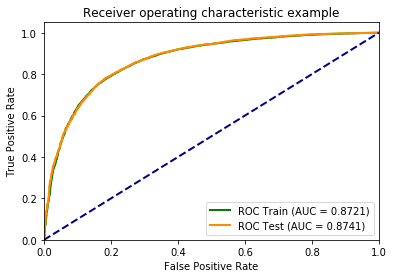

In [16]:
predict_and_evaluate_performance(lr_model, train, test)

In [17]:
# Predict
# lr_pred_train = predictions(lr_model, train)
# lr_pred_test = predictions(lr_model, test)

# y_train = lr_pred_train['label']
# p_train_pred = [v[1] for v in lr_pred_train['probability']]

# y_test = lr_pred_test['label']
# p_test_pred = [v[1] for v in lr_pred_test['probability']]

# # Evaluate
# plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

### Random Forest

In [18]:
rf = RandomForestClassifier(labelCol='label',
                            featuresCol='features',
                            numTrees=50,
                            featureSubsetStrategy='auto',
                            impurity='gini',
                            maxDepth=12,
                            minInstancesPerNode=10,
                            maxBins=16)
rf_model = rf.fit(train)

#### Predict and evaluate performance

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.37658777738944...|       1.0|    1|(28,[3,4,15,21,22...|
|[0.83708721783511...|       0.0|    0|[0.0,6.0,12.0,19....|
|[0.87446216067379...|       0.0|    0|(28,[2,3,4,8,9,14...|
|[0.09050993595197...|       1.0|    1|(28,[4,15,22,27],...|
|[0.82394035952377...|       0.0|    0|(28,[2,3,4,7,8,9,...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.96766346367559...|       0.0|    0|(28,[1,2,3,4,9,13...|
|[0.96640999355587...|       0.0|    0|[0.0,3.0,67.0,212...|
|[0.71687256352853...|       0.0|    0|(28,[1,2,3,4,9,14...|
|[0.88592797756553...|       0.0|    0|[0.0,47.0,49.0,49...|

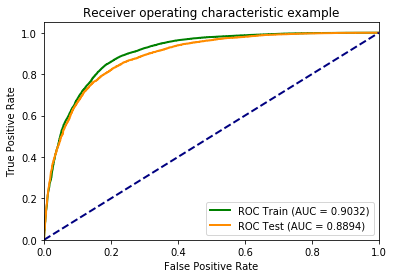

In [19]:
predict_and_evaluate_performance(rf_model, train, test)

In [20]:
# # Predict
# rf_pred_train = predictions(rf_model, train)
# rf_pred_test = predictions(rf_model, test)

# y_train = rf_pred_train['label']
# p_train_pred = [v[1] for v in rf_pred_train['probability']]

# y_test = pred_test['label']
# p_test_pred = [v[1] for v in rf_pred_test['probability']]

# # Evaluate
# plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)